# SPAM Dataset visualization

Useful imports

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.preprocessing import data_spam, preprocessing, visualize

Here we charge the dataframe from the spambase : 4600 emails with 58 features

In [ ]:
df = pd.read_csv(data_spam)
df

,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,...,0.41,0.42,0.43,0.778,0.44,0.45,3.756,61,278,1
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.000,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4596,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4597,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4598,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


We see that the columns are labeled as numbers like 0.1, 0.41... which does not help the understanding of the data. 

Thankfully, we have access to a .NAMES file with the name of the different columns. Using it we can create a list with the real names :

In [3]:
colonnes = [
    "word_freq_make",
    "word_freq_address",
    "word_freq_all",
    "word_freq_3d",
    "word_freq_our",
    "word_freq_over",
    "word_freq_remove",
    "word_freq_internet",
    "word_freq_order",
    "word_freq_mail",
    "word_freq_receive",
    "word_freq_will",
    "word_freq_people",
    "word_freq_report",
    "word_freq_addresses",
    "word_freq_free",
    "word_freq_business",
    "word_freq_email",
    "word_freq_you",
    "word_freq_credit",
    "word_freq_your",
    "word_freq_font",
    "word_freq_000",
    "word_freq_money",
    "word_freq_hp",
    "word_freq_hpl",
    "word_freq_george",
    "word_freq_650",
    "word_freq_lab",
    "word_freq_labs",
    "word_freq_telnet",
    "word_freq_857",
    "word_freq_data",
    "word_freq_415",
    "word_freq_85",
    "word_freq_technology",
    "word_freq_1999",
    "word_freq_parts",
    "word_freq_pm",
    "word_freq_direct",
    "word_freq_cs",
    "word_freq_meeting",
    "word_freq_original",
    "word_freq_project",
    "word_freq_re",
    "word_freq_edu",
    "word_freq_table",
    "word_freq_conference",
    "char_freq_;",
    "char_freq_(",
    "char_freq_[",
    "char_freq_!",
    "char_freq_$",
    "char_freq_#",
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total",
    "is_spam",
]

We then change the name of the columns :

In [4]:
df.columns = colonnes

And verify with the .info() method.

We also check that there is no missing values in each of the columns

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4600 non-null   float64
 1   word_freq_address           4600 non-null   float64
 2   word_freq_all               4600 non-null   float64
 3   word_freq_3d                4600 non-null   float64
 4   word_freq_our               4600 non-null   float64
 5   word_freq_over              4600 non-null   float64
 6   word_freq_remove            4600 non-null   float64
 7   word_freq_internet          4600 non-null   float64
 8   word_freq_order             4600 non-null   float64
 9   word_freq_mail              4600 non-null   float64
 10  word_freq_receive           4600 non-null   float64
 11  word_freq_will              4600 non-null   float64
 12  word_freq_people            4600 non-null   float64
 13  word_freq_report            4600 

Using the .DOCUMENTATION file, we learn that each feature named "word_freq_*WORD*" represent the percentage of word in the email which **are** the word *WORD*. (48 features of this type)

For exemple :
- **word_freq_credit** gives the percentage of word in the email that match the word "*credit*"
- **word_freq_report** same with word "*report*"

6 features are named "char_freq_*CHAR*" which is the same as before but with a character *CHAR*.

Exemples :
- **char_freq_;**
- **char_freq_$**

The remaining columns are : 

**capital_run_length_average** = average length of uninterrupted sequences of capital letters

**capital_run_length_longest** = length of longest uninterrupted sequence of capital letters

**capital_run_length_total** = sum of length of uninterrupted sequences of capital letters = total number of capital letters in the e-mail

**is_spam** = denotes whether the e-mail was considered spam (1) or not (0),  i.e. unsolicited commercial e-mail

In [6]:
df.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
count,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,...,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,0.104576,0.212922,0.280578,0.065439,0.312222,0.095922,0.114233,0.105317,0.090087,0.239465,...,0.038583,0.139061,0.016980,0.268960,0.075827,0.044248,5.191827,52.170870,283.290435,0.393913
std,0.305387,1.290700,0.504170,1.395303,0.672586,0.273850,0.391480,0.401112,0.278643,0.644816,...,0.243497,0.270377,0.109406,0.815726,0.245906,0.429388,31.732891,194.912453,606.413764,0.488669
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.275500,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.382500,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.314250,0.052000,0.000000,3.705250,43.000000,265.250000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


We check the number of spam in the dataset :

In [7]:
df["is_spam"].value_counts()

is_spam
0    2788
1    1812
Name: count, dtype: int64

For some of the features we can see how the data is distributed, distinguishing spam and no spam, and the different correlations
Most of the other features have their density concentrated around 0.

['word_freq_all', 'word_freq_our', 'word_freq_you', 'word_freq_your', 'word_freq_will', 'word_freq_make']
Features choisies : ['word_freq_all', 'word_freq_our', 'word_freq_you', 'word_freq_your', 'word_freq_will', 'word_freq_make']


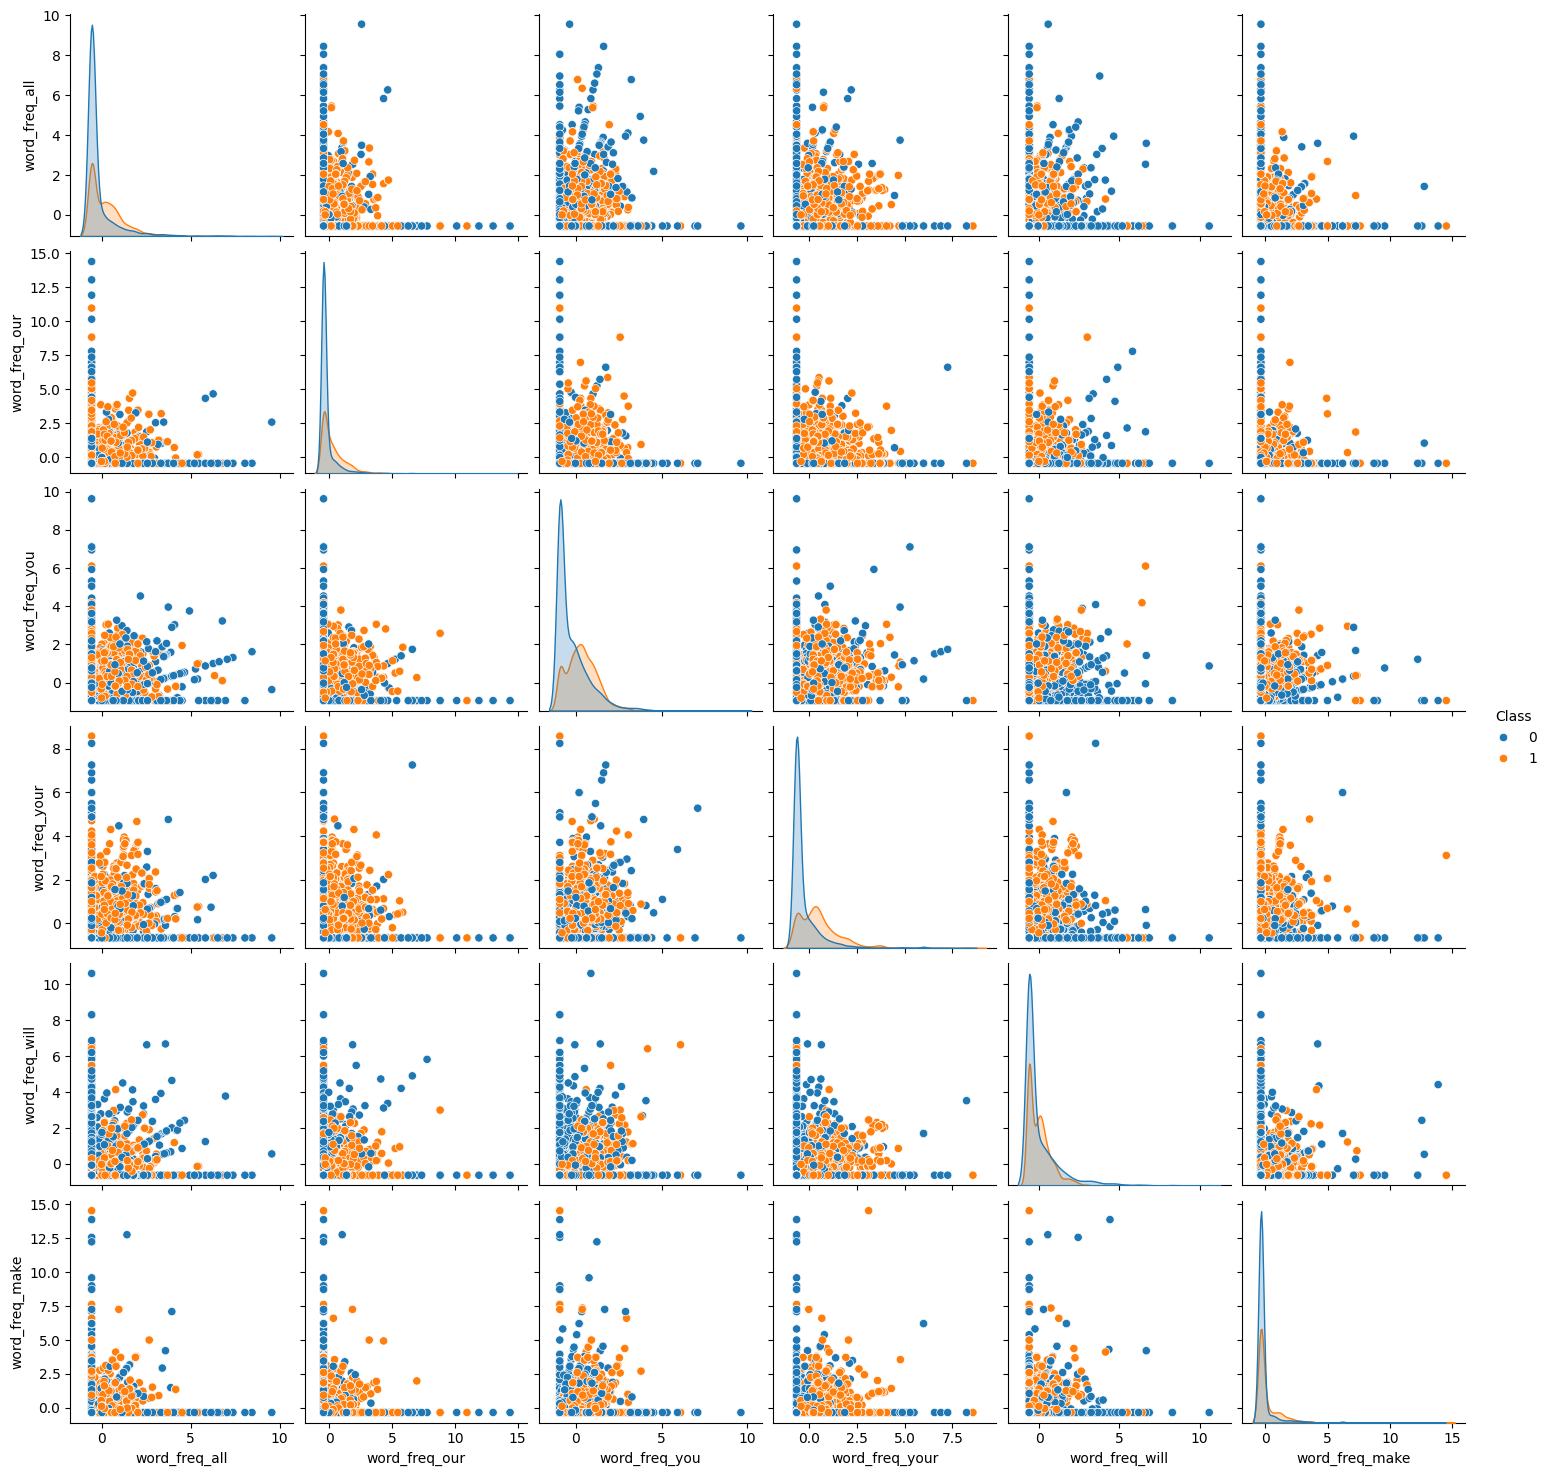

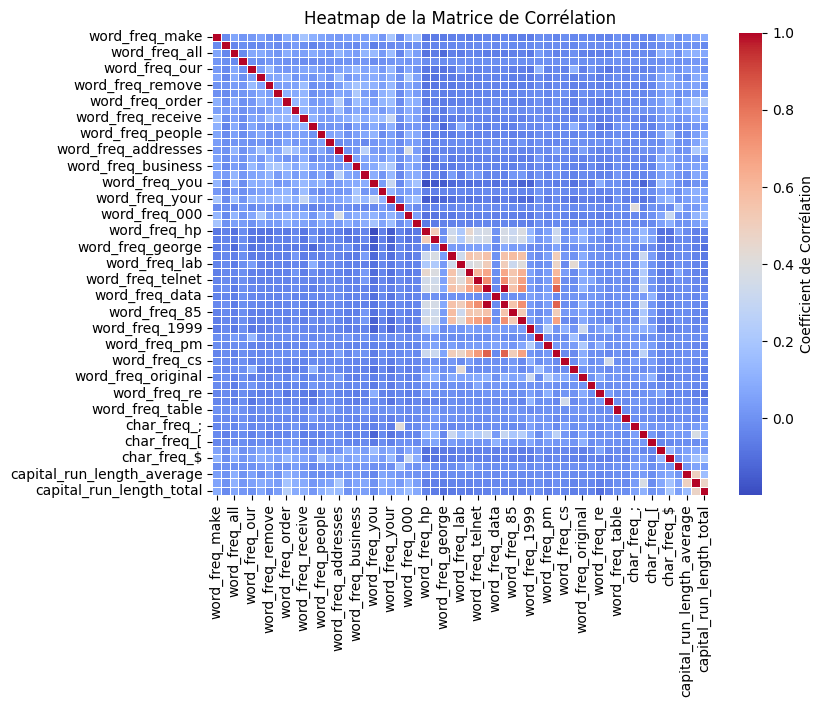

In [27]:
visualize(data_spam, features)

# K nearest neighbour


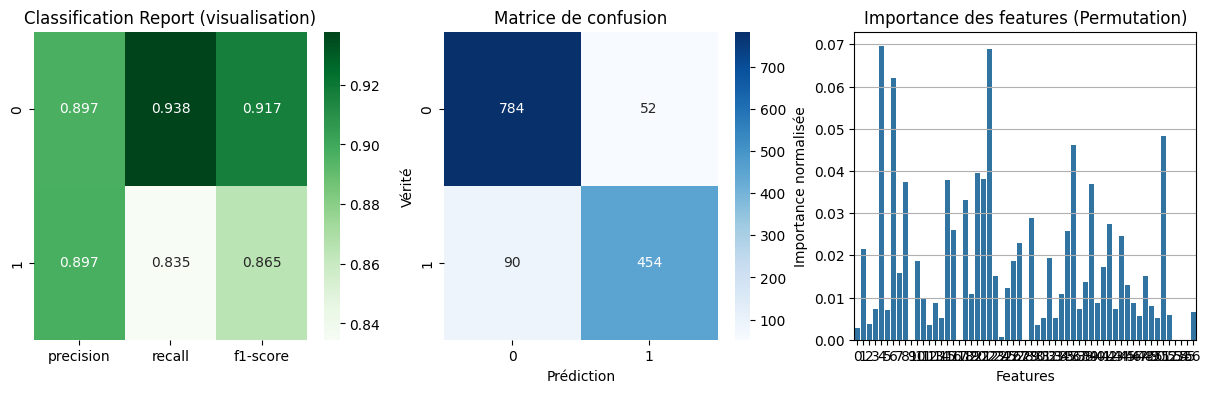

In [14]:
from src.knn import KNNModel

samples = preprocessing(data=data_spam, test_size=0.3, validation_size=0.1)
model = KNNModel()
model.train(x=samples.X_train, y=samples.y_train)
model.benchmark(x=samples.X_test, y=samples.y_test)

## Analysis


# Neural network : MLP

In [2]:
from src.nn_interface import MLPModel

samples = preprocessing(data=data_spam, test_size=0.15, validation_size=0.15)
model = MLPModel(input_size=57)
model.train(samples)

epoch: 1 	training Loss: 1.097946 
Validation loss improved → new best = 1.035776
epoch: 2 	training Loss: 0.995367 
Validation loss improved → new best = 0.894269
epoch: 3 	training Loss: 0.837341 
Validation loss improved → new best = 0.695794
epoch: 4 	training Loss: 0.645190 
Validation loss improved → new best = 0.519186
epoch: 5 	training Loss: 0.516077 
Validation loss improved → new best = 0.424280
epoch: 6 	training Loss: 0.453513 
Validation loss improved → new best = 0.394985
epoch: 7 	training Loss: 0.413982 
Validation loss improved → new best = 0.383423
epoch: 8 	training Loss: 0.395290 
Validation loss improved → new best = 0.377364
epoch: 9 	training Loss: 0.361027 
Validation loss improved → new best = 0.366129
epoch: 10 	training Loss: 0.355046 
Validation loss improved → new best = 0.358642
epoch: 11 	training Loss: 0.334673 
Validation loss improved → new best = 0.353741
epoch: 12 	training Loss: 0.310001 
Validation loss improved → new best = 0.349166
epoch: 13 	tr

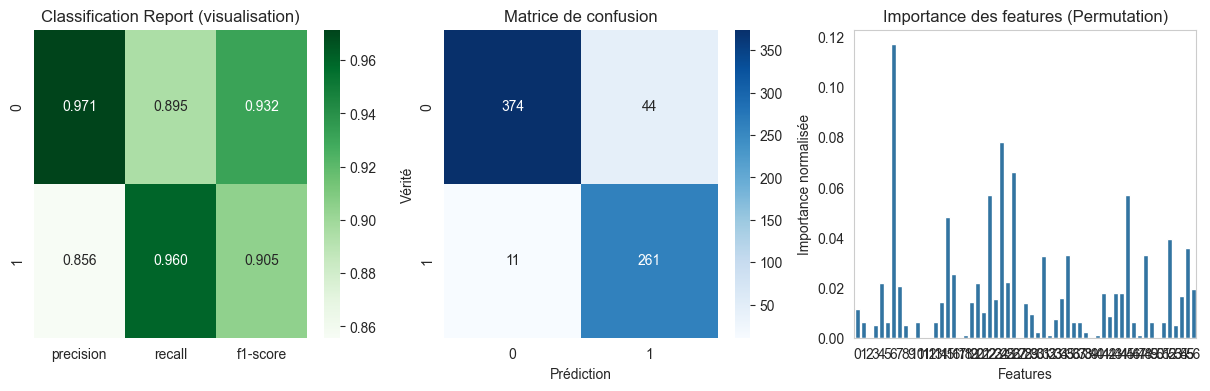

In [4]:
model.benchmark(samples.X_test, samples.y_test)

# Random Forest

In [15]:
from src.RForest import RForest

samples = preprocessing(data=data_spam, test_size=0.3, validation_size=0.1)
model = RForest()
model.train(x=samples.X_train, y=samples.y_train)

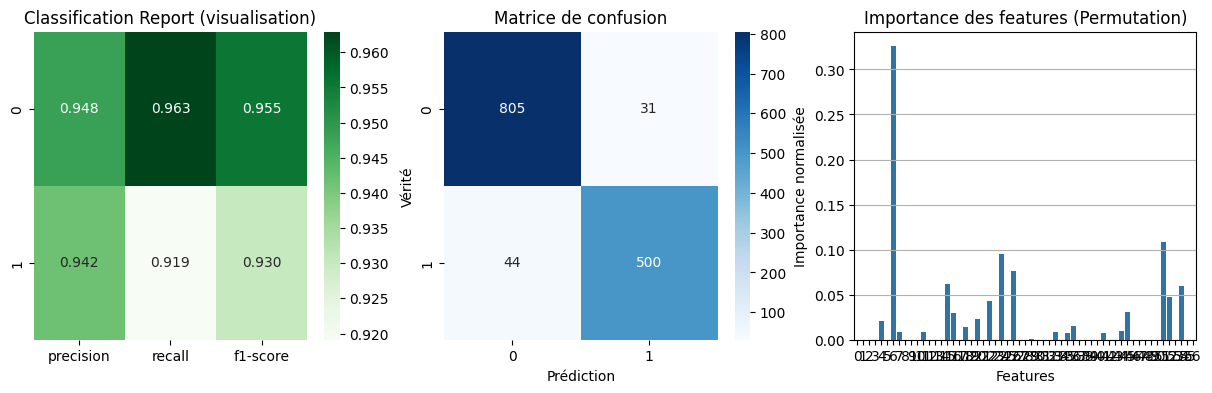

In [16]:
model.benchmark(x=samples.X_test, y=samples.y_test)

# Linear SVC

In [12]:
from src.kernel_methods import LinearSVC_

samples = preprocessing(data=data_spam, test_size=0.3, validation_size=0.1)
model = LinearSVC_()
model.train(x=samples.X_train, y=samples.y_train)

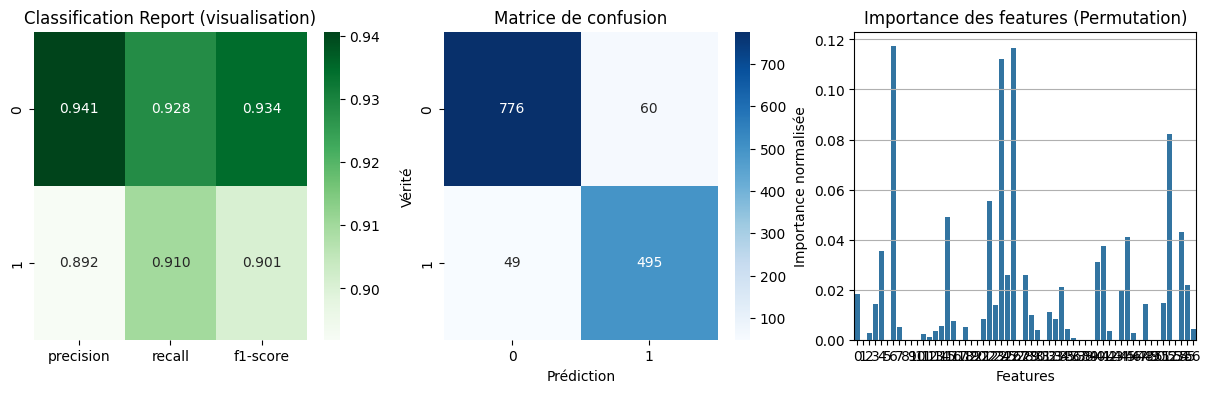

In [13]:
model.benchmark(x=samples.X_test, y=samples.y_test)